# Attention Visualization

This notebook reproduces the attention visualization figures:
- **Fig 4**: Cross-image attention from keypoints (layer 15)
- **Fig S8**: Layer 0 attention (early layer, minimal differentiation)
- **Fig S9**: Layer 15 attention (additional trials)

**Requires GPU**: This notebook loads VGGT and extracts attention maps.

You can either:
1. Run `python scripts/run_attention.py --gpu_id <GPU>` first, then load pre-extracted data below
2. Or run the live extraction cells directly (requires GPU)

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from human_multiview.config import RESULTS_DIR, N_LAYERS
from human_multiview.data import load_mochi, get_trial_images
from human_multiview.models import get_model
from human_multiview.models.base import clear_gpu_memory
from human_multiview.attention import (
    AttentionExtractor,
    extract_attention,
    plot_attention_figure,
)
from human_multiview.plotting import set_paper_style

set_paper_style()

## Load dataset and model

In [2]:
dataset = load_mochi()
print(f"Loaded {len(dataset)} trials")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

ModelClass = get_model("vggt")
vggt = ModelClass()
vggt.load(device)

extractor = AttentionExtractor(vggt.model)

Loaded 2019 trials
Device: cuda


## Define trials and keypoints

Edit the cells below to choose which trials and keypoints to visualize.
Default examples from the manuscript are pre-filled.

In [3]:
def find_trial_by_name(dataset, name):
    """Find trial index by name."""
    for i in range(len(dataset)):
        if dataset[i]["trial"] == name:
            return i
    return None


def find_trials_by_condition(dataset, condition, n=1):
    """Find trial indices for a given condition."""
    indices = []
    for i in range(len(dataset)):
        if dataset[i]["dataset"] == condition:
            indices.append(i)
            if len(indices) >= n:
                break
    return indices


def show_trial(dataset, trial_idx):
    """Display the three images of a trial."""
    trial = dataset[trial_idx]
    img_A, img_Ap, img_B, info = get_trial_images(trial)
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for ax, img, title in zip(axes, [img_A, img_Ap, img_B], ["A", "A'", "B"]):
        ax.imshow(img)
        ax.set_title(title, fontsize=14)
        ax.axis("off")
    fig.suptitle(f"Trial {trial_idx}: {info['trial_name']} ({info['dataset']})", fontsize=12)
    plt.tight_layout()
    plt.show()
    return img_A, img_Ap, img_B, info

In [4]:
# Example trials — edit these to explore different trials
# Each entry: (trial_index, list of (x, y) keypoints on image A)
# Keypoints are in pixel coordinates of the original image.

# Find example trials from different conditions
shapegen_trials = find_trials_by_condition(dataset, "shapegen", n=3)
barense_trials = find_trials_by_condition(dataset, "barense", n=3)
shapenet_trials = find_trials_by_condition(dataset, "shapenet", n=3)

# Use the first trial from each condition for the main figures
trial_configs = []

for trial_idx in [shapegen_trials[0], barense_trials[0]]:
    trial = dataset[trial_idx]
    img_A, img_Ap, img_B, info = get_trial_images(trial)
    w, h = img_A.size
    # Auto-generate keypoints in a grid over the center of the image
    keypoints = [
        (int(w * 0.35), int(h * 0.35)),
        (int(w * 0.65), int(h * 0.35)),
        (int(w * 0.35), int(h * 0.65)),
        (int(w * 0.65), int(h * 0.65)),
        (int(w * 0.50), int(h * 0.50)),
    ]
    trial_configs.append((trial_idx, keypoints))
    print(f"Trial {trial_idx}: {info['trial_name']} ({info['dataset']}) — {len(keypoints)} keypoints")

print(f"\nTotal: {len(trial_configs)} trial configurations")

Trial 1471: shapegen1500 (shapegen) — 5 keypoints
Trial 0: familiar_high_screen01 (barense) — 5 keypoints

Total: 2 trial configurations


## Preview trials

View the trial images and keypoint locations before extracting attention.

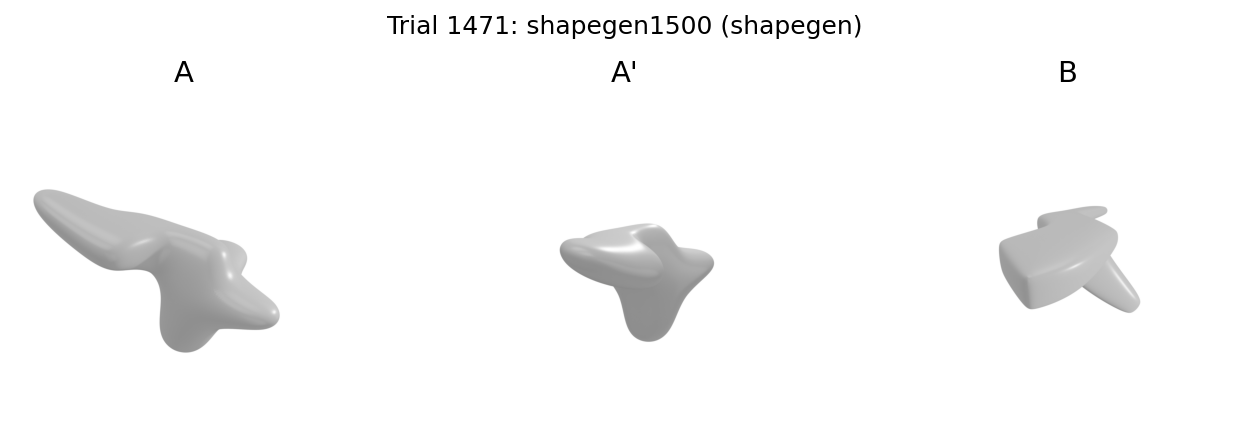

  Keypoints: [(350, 350), (650, 350), (350, 650), (650, 650), (500, 500)]


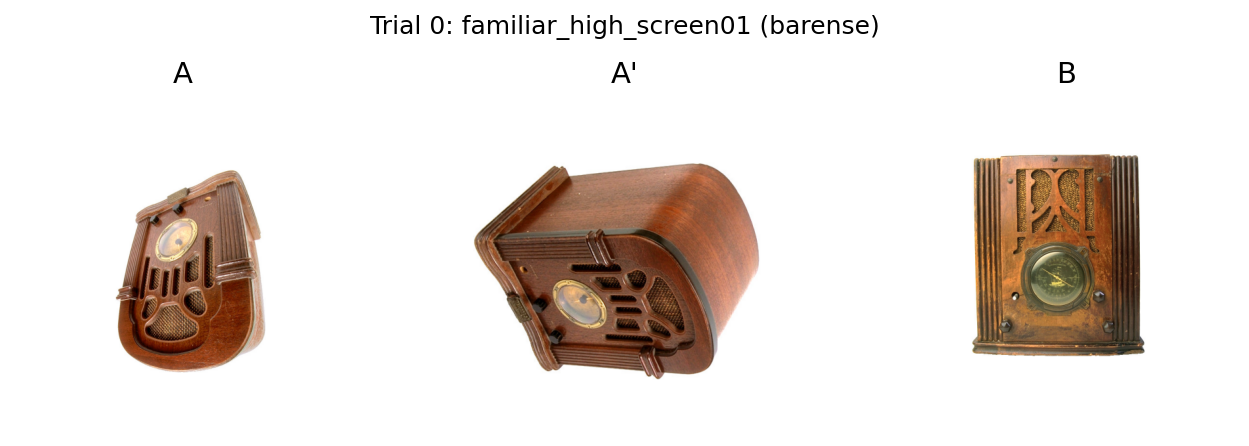

  Keypoints: [(179, 179), (332, 179), (179, 332), (332, 332), (256, 256)]


In [5]:
for trial_idx, keypoints in trial_configs:
    img_A, img_Ap, img_B, info = show_trial(dataset, trial_idx)
    print(f"  Keypoints: {keypoints}")

## Fig 4: Cross-image attention (layer 15)

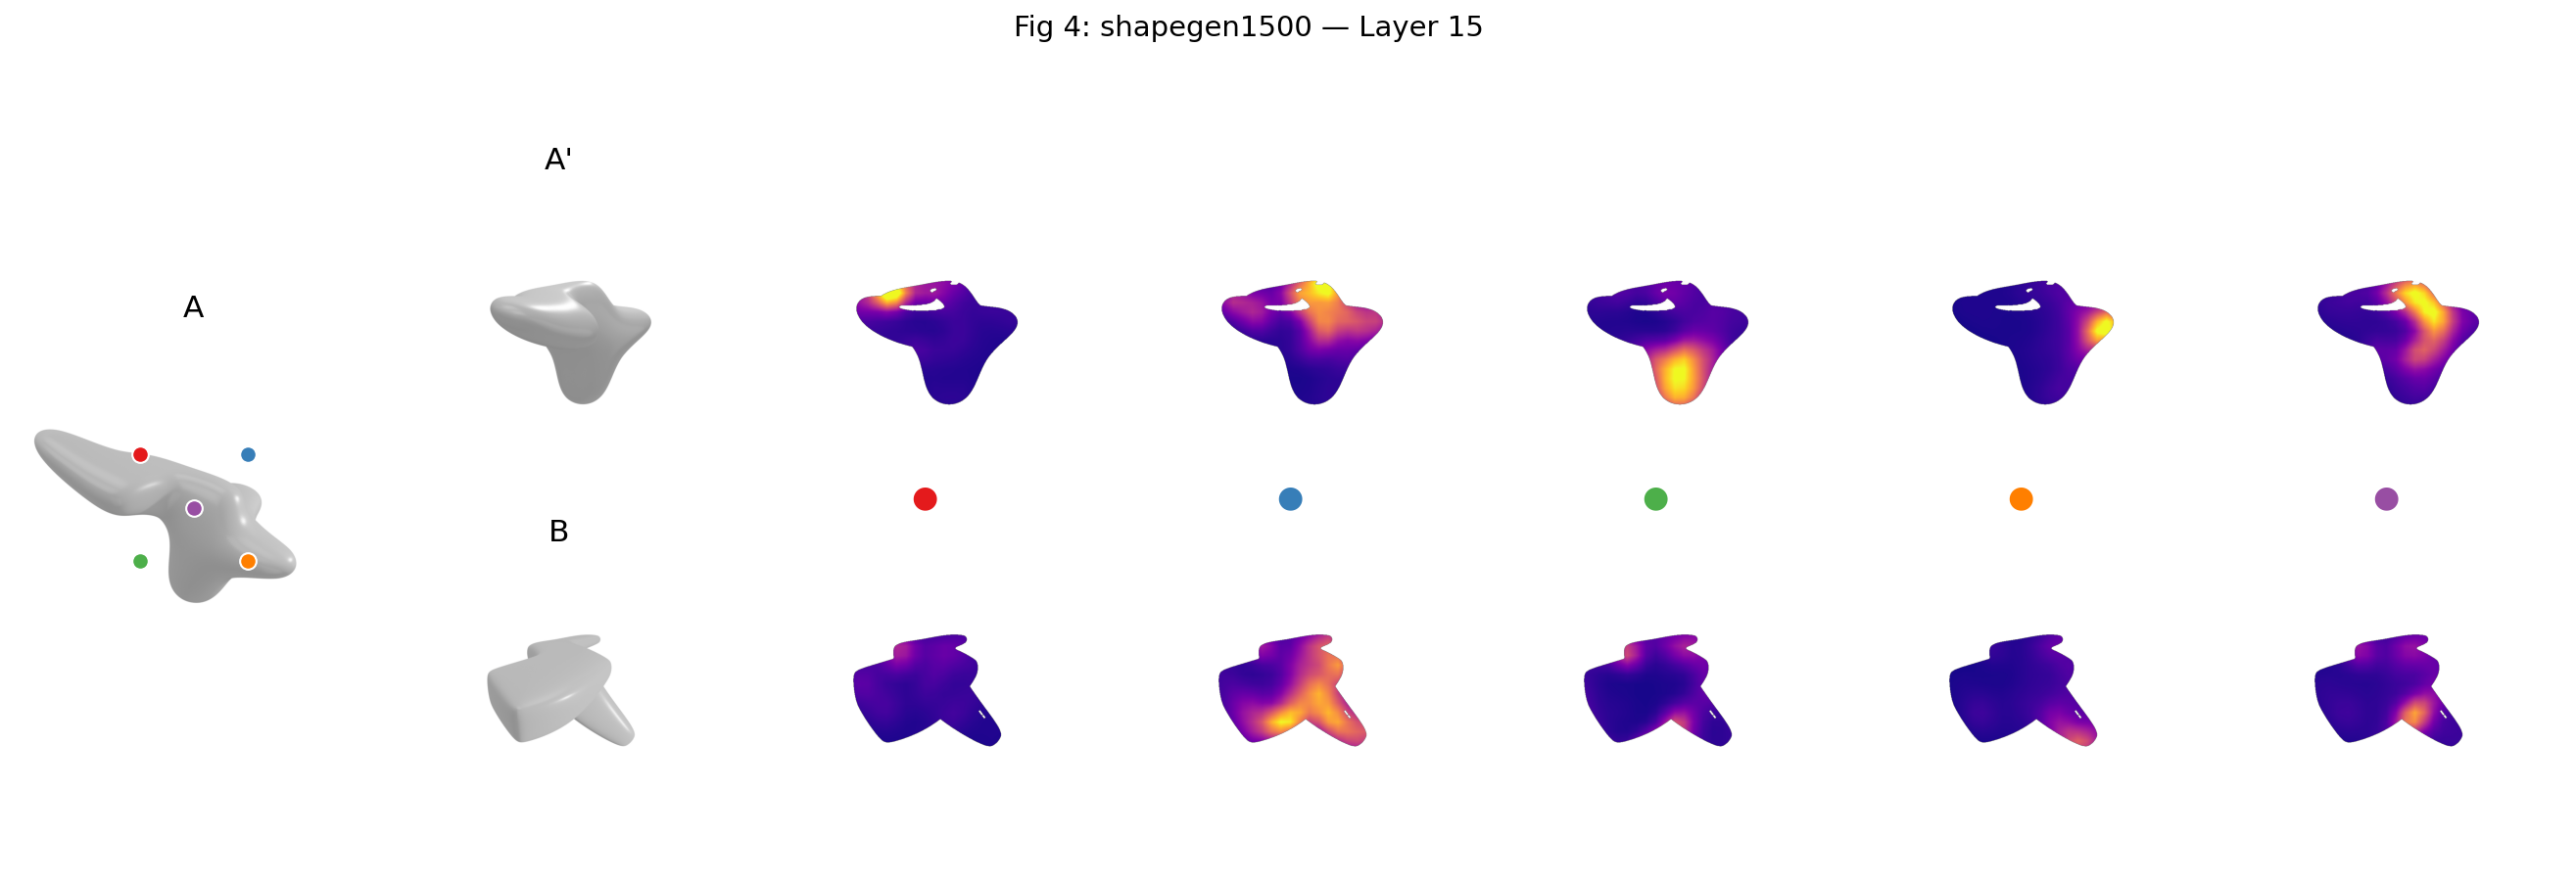

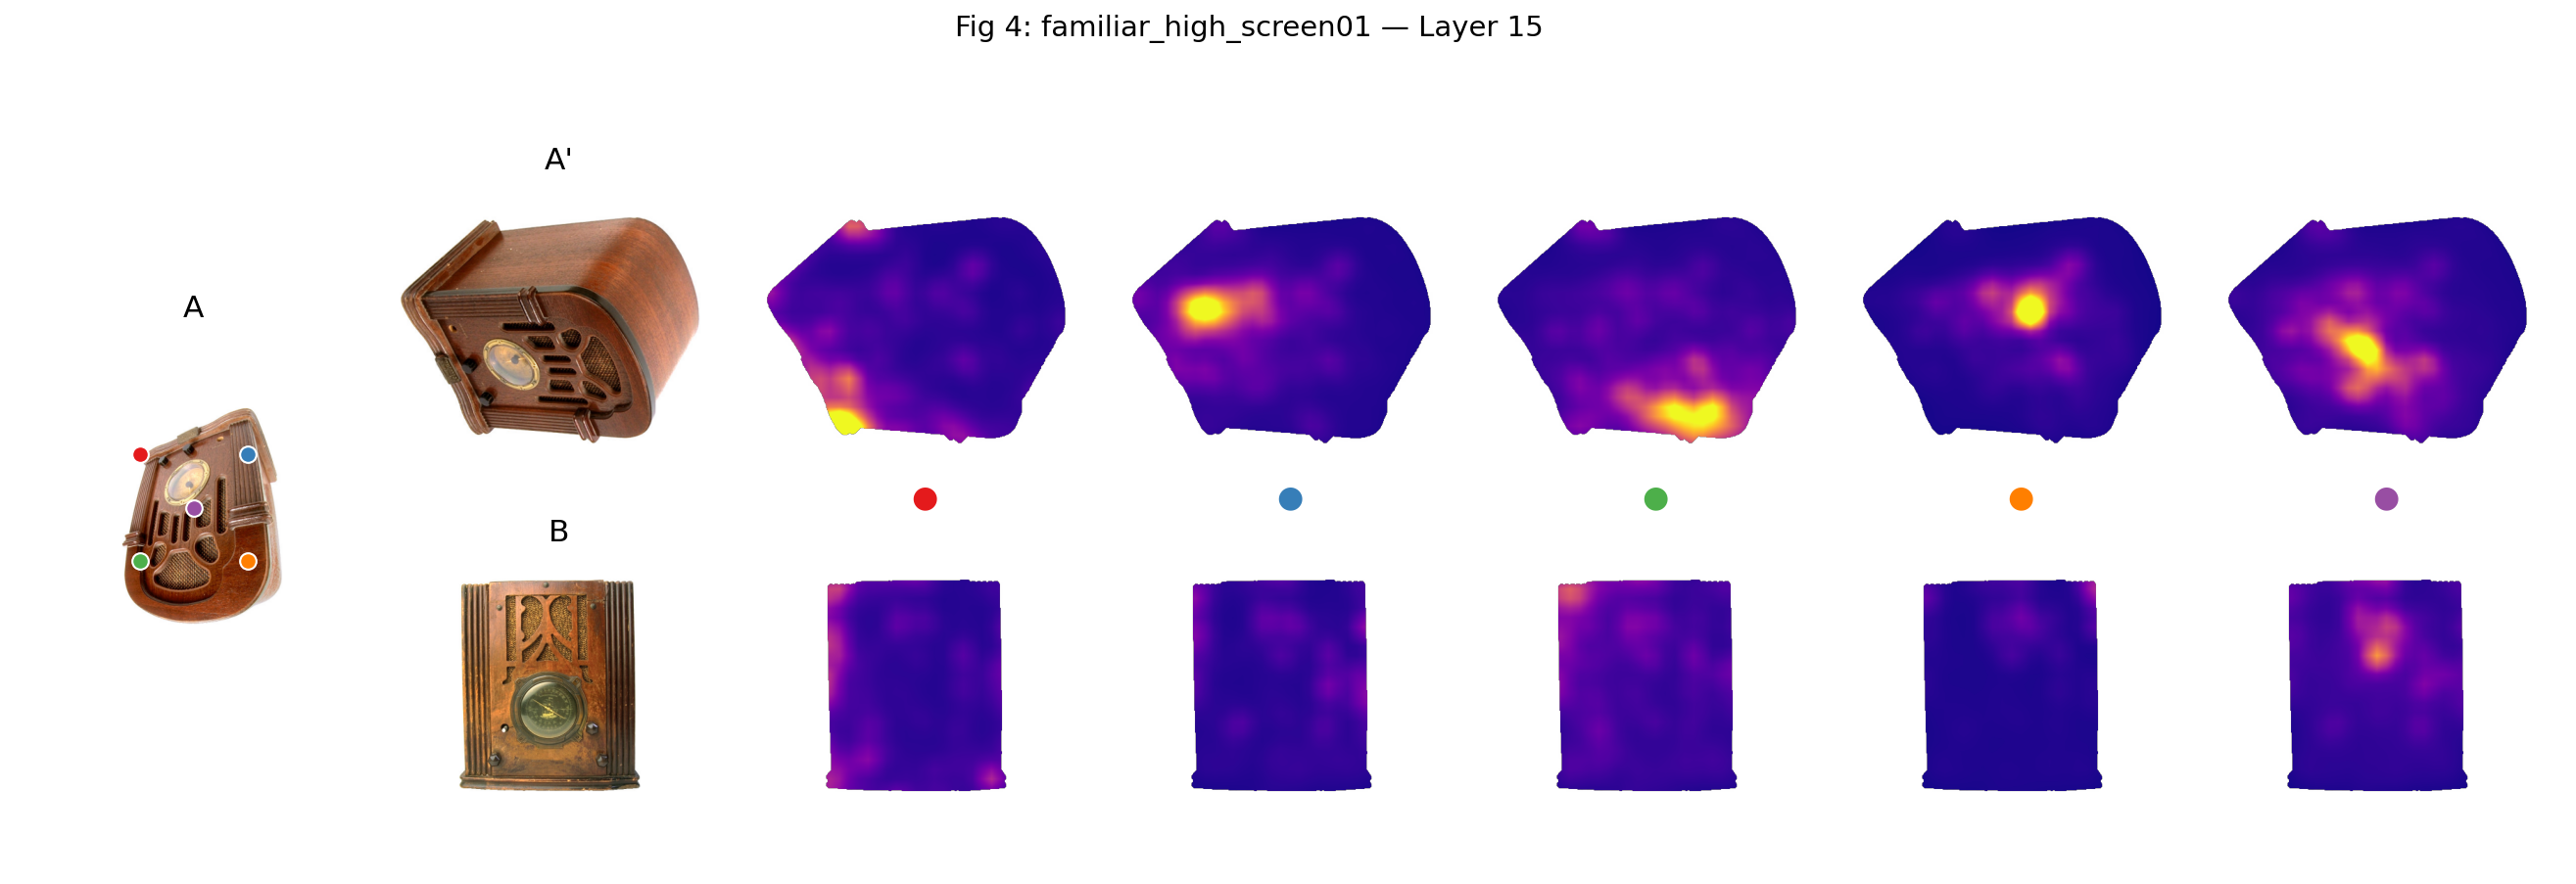

In [6]:
layer = 15

for trial_idx, keypoints in trial_configs:
    trial = dataset[trial_idx]
    img_A, img_Ap, img_B, info = get_trial_images(trial)

    # Extract attention for A→A' pair
    attn_maps_Ap, patch_info = extract_attention(
        vggt, img_A, img_Ap, extractor, (layer,)
    )

    # Extract attention for A→B pair
    attn_maps_B, _ = extract_attention(
        vggt, img_A, img_B, extractor, (layer,)
    )

    fig = plot_attention_figure(
        img_A, img_Ap, img_B, keypoints,
        attn_maps_Ap, attn_maps_B, patch_info,
        layer=layer, head="mean", sigma=1.0,
        include_B=True, mask_attention=True,
    )
    fig.suptitle(
        f"Fig 4: {info['trial_name']} — Layer {layer}",
        fontsize=14, y=1.02
    )
    plt.savefig(RESULTS_DIR / f"fig4_attention_L{layer}_{info['dataset']}_{trial_idx}.pdf",
                bbox_inches="tight")
    plt.show()

    del attn_maps_Ap, attn_maps_B
    clear_gpu_memory()

## Fig S8: Early layer attention (layer 0)

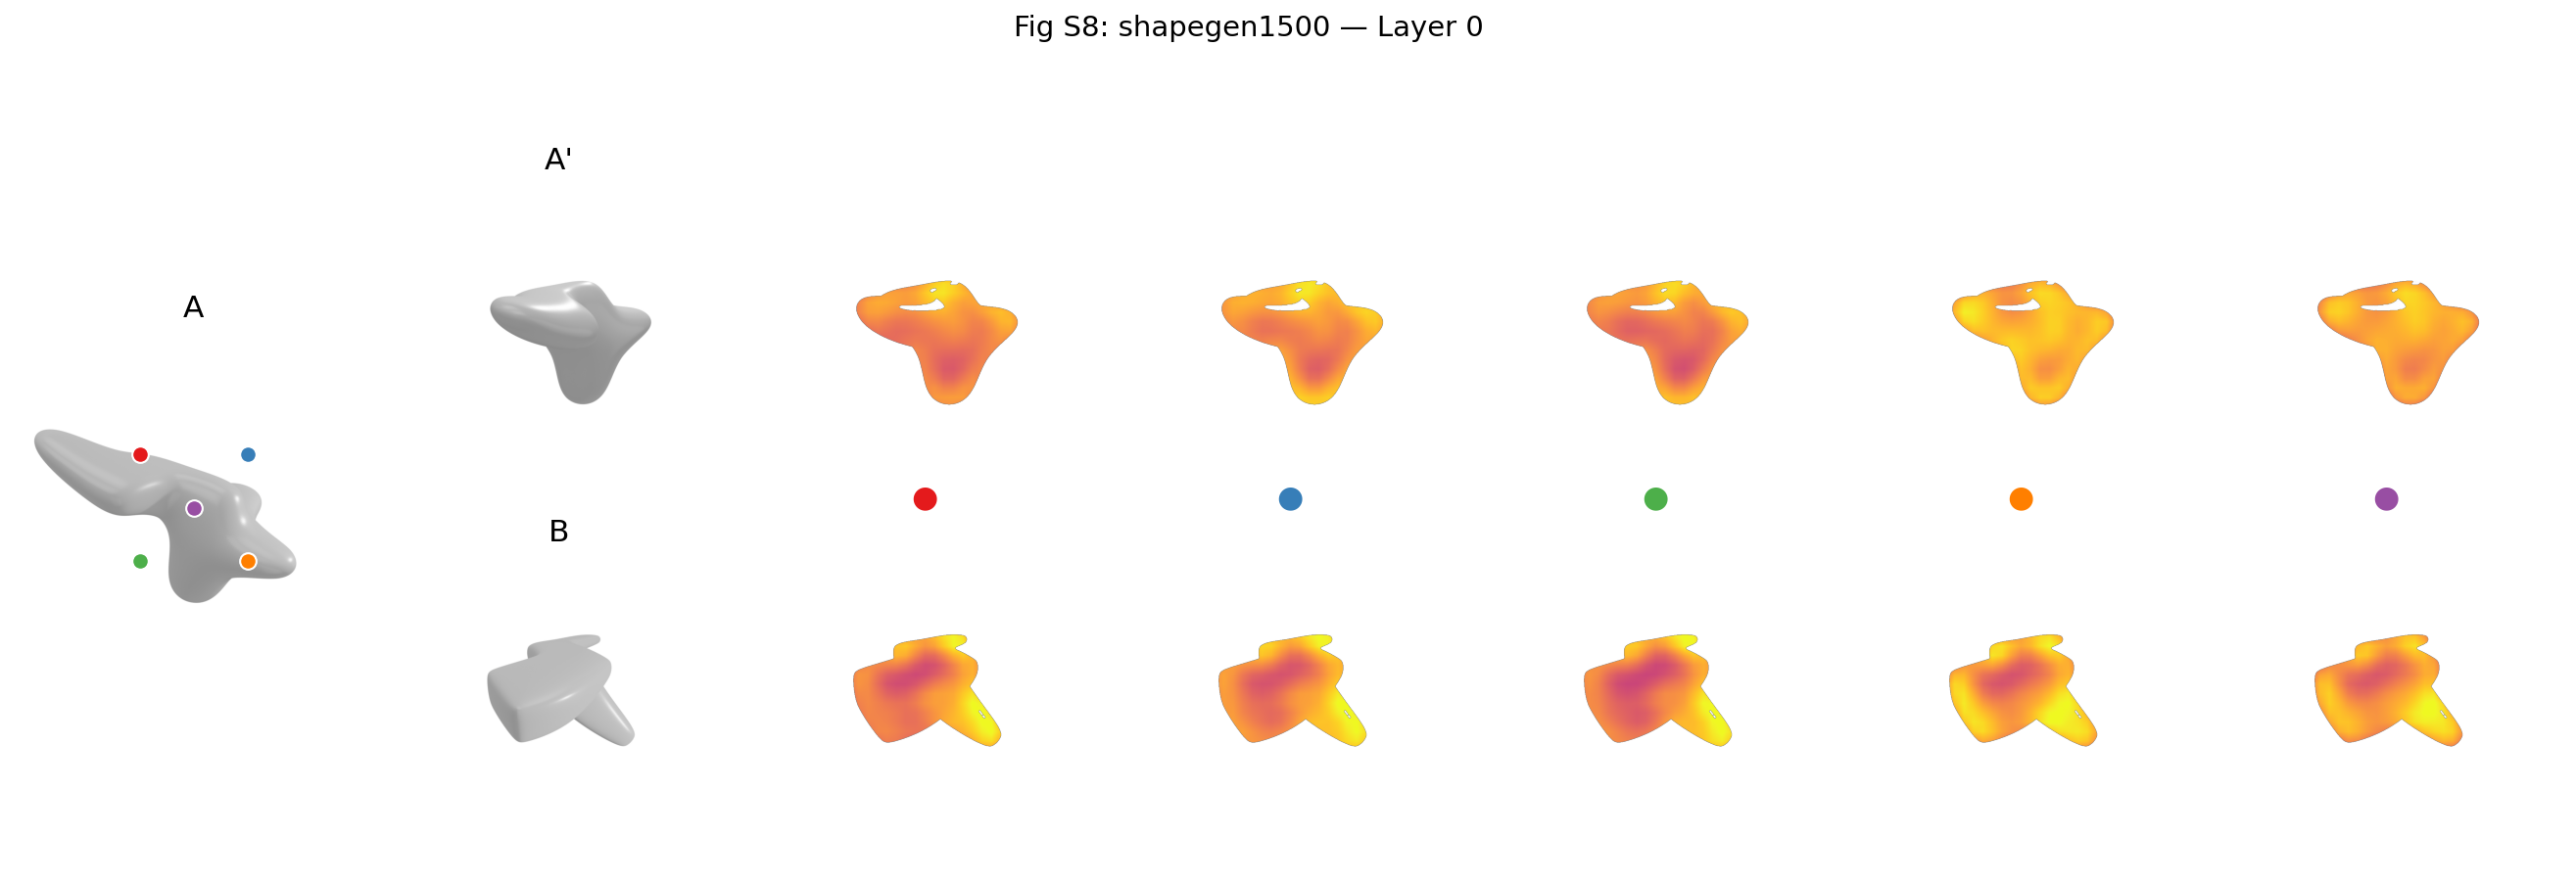

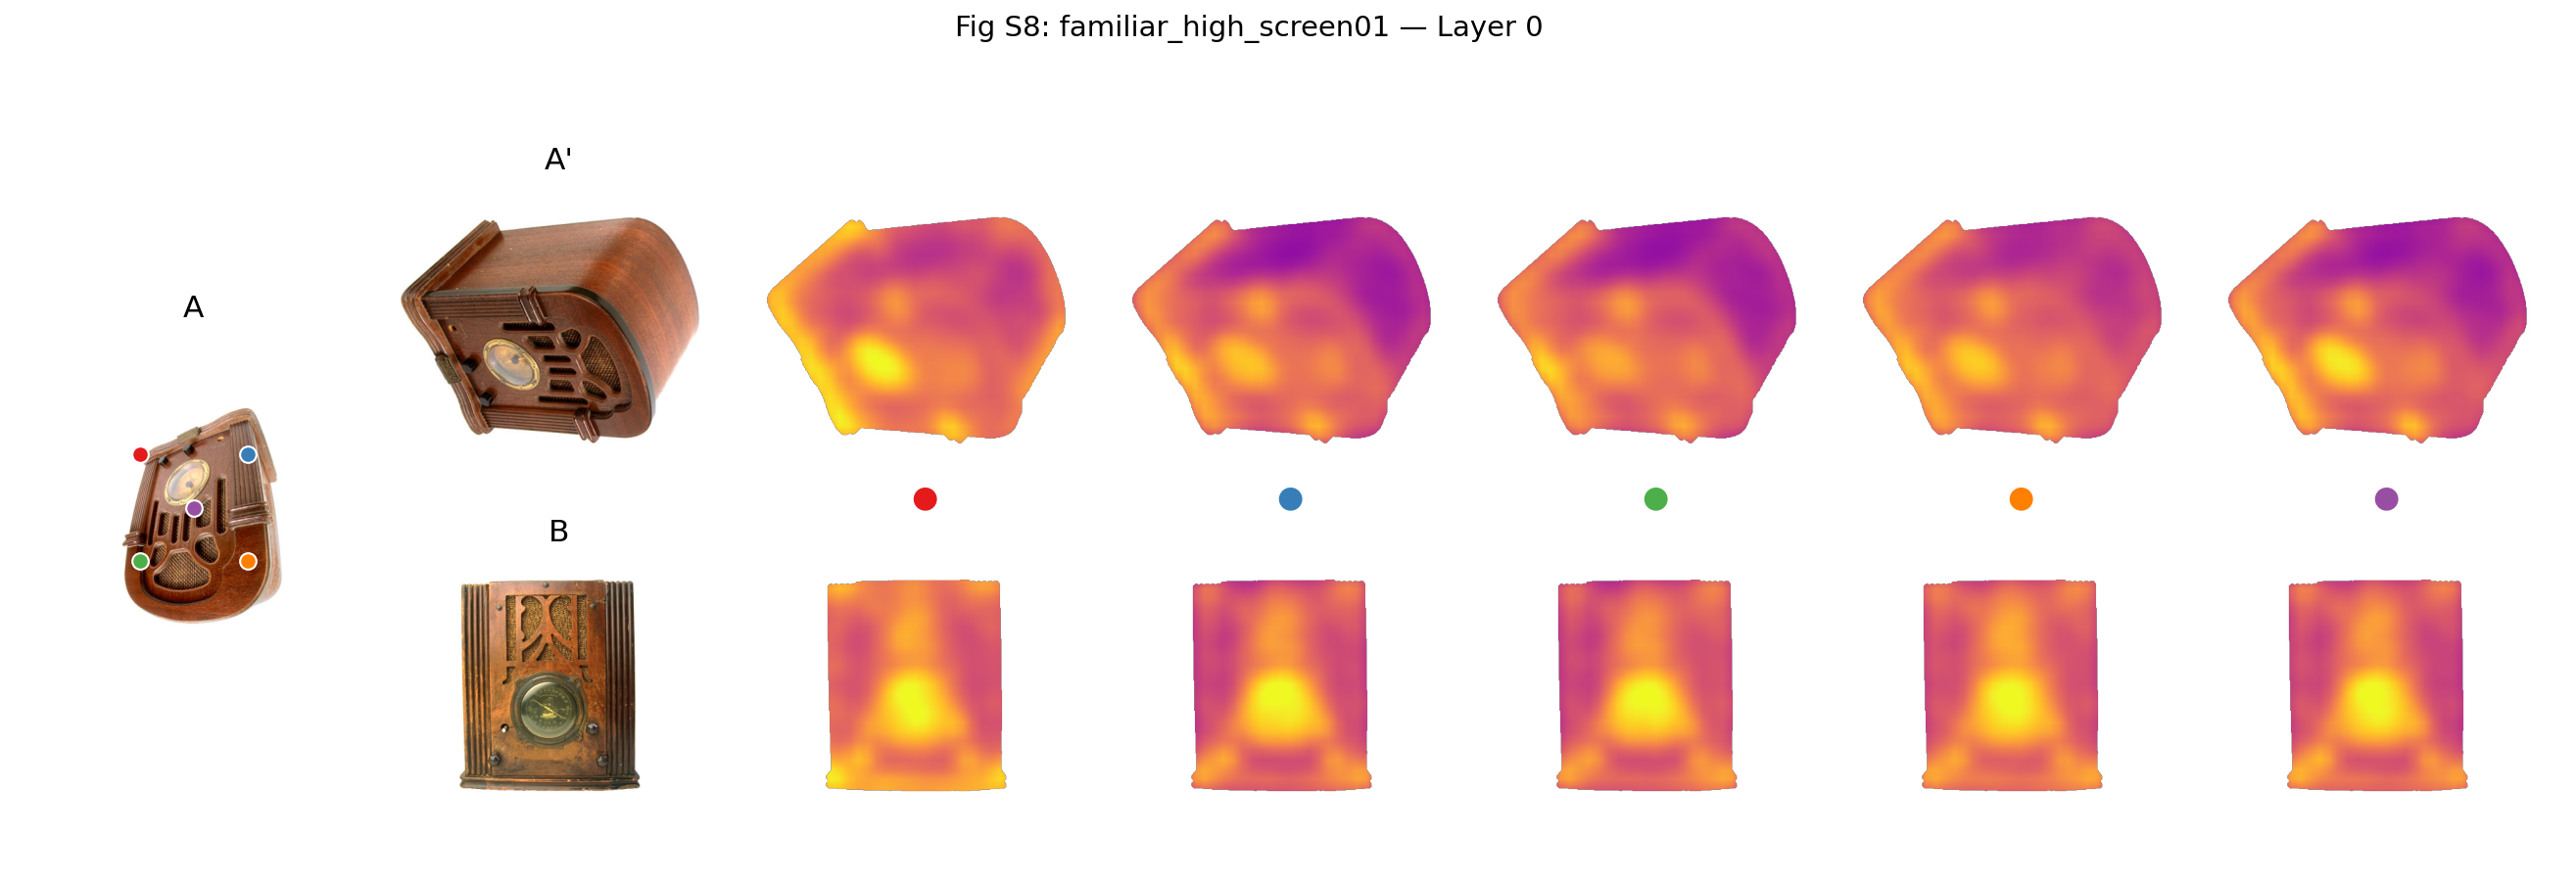

In [7]:
layer = 0

for trial_idx, keypoints in trial_configs:
    trial = dataset[trial_idx]
    img_A, img_Ap, img_B, info = get_trial_images(trial)

    attn_maps_Ap, patch_info = extract_attention(
        vggt, img_A, img_Ap, extractor, (layer,)
    )
    attn_maps_B, _ = extract_attention(
        vggt, img_A, img_B, extractor, (layer,)
    )

    fig = plot_attention_figure(
        img_A, img_Ap, img_B, keypoints,
        attn_maps_Ap, attn_maps_B, patch_info,
        layer=layer, head="mean", sigma=1.0,
        include_B=True, mask_attention=True,
    )
    fig.suptitle(
        f"Fig S8: {info['trial_name']} — Layer {layer}",
        fontsize=14, y=1.02
    )
    plt.savefig(RESULTS_DIR / f"fig_s8_attention_L{layer}_{info['dataset']}_{trial_idx}.pdf",
                bbox_inches="tight")
    plt.show()

    del attn_maps_Ap, attn_maps_B
    clear_gpu_memory()

## Fig S9: Layer 15 attention (additional trials)

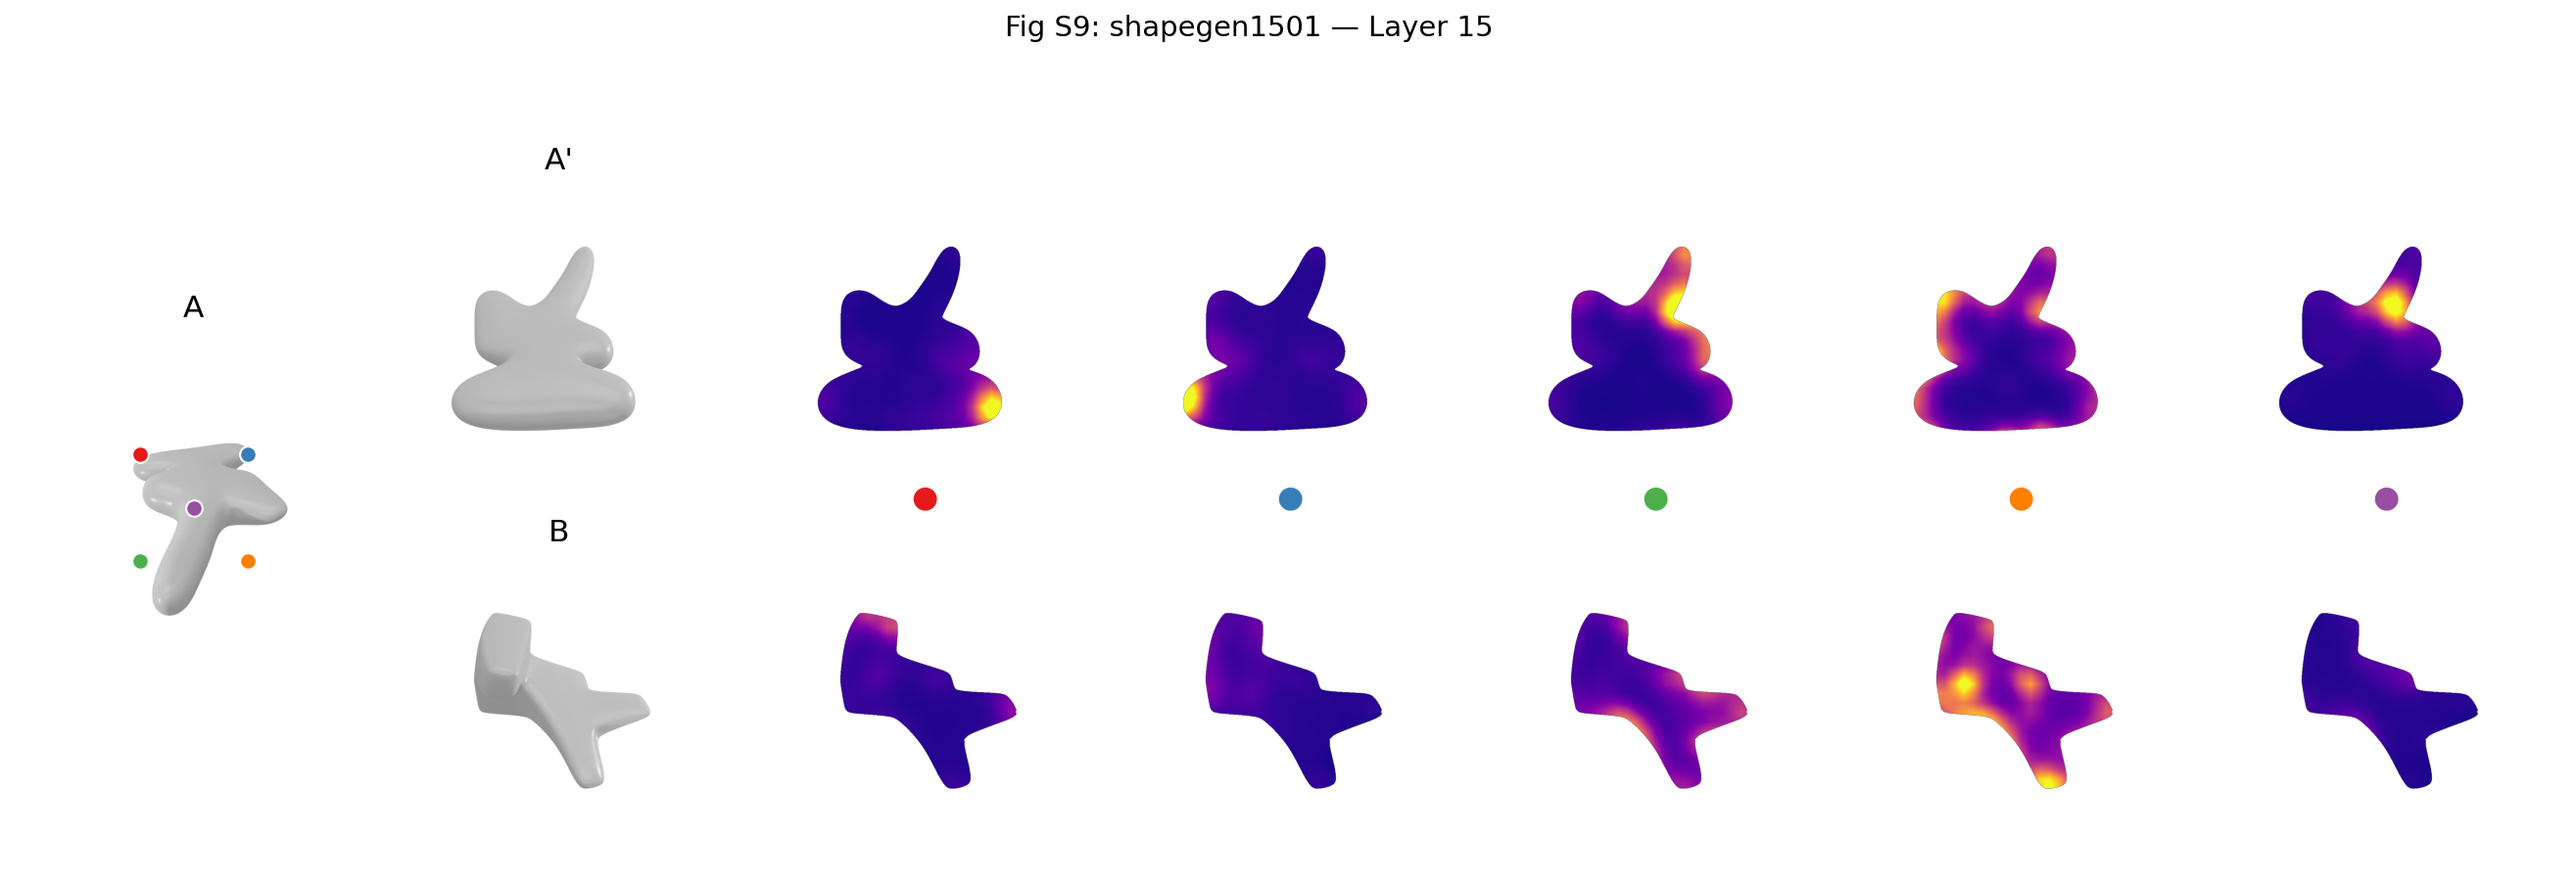

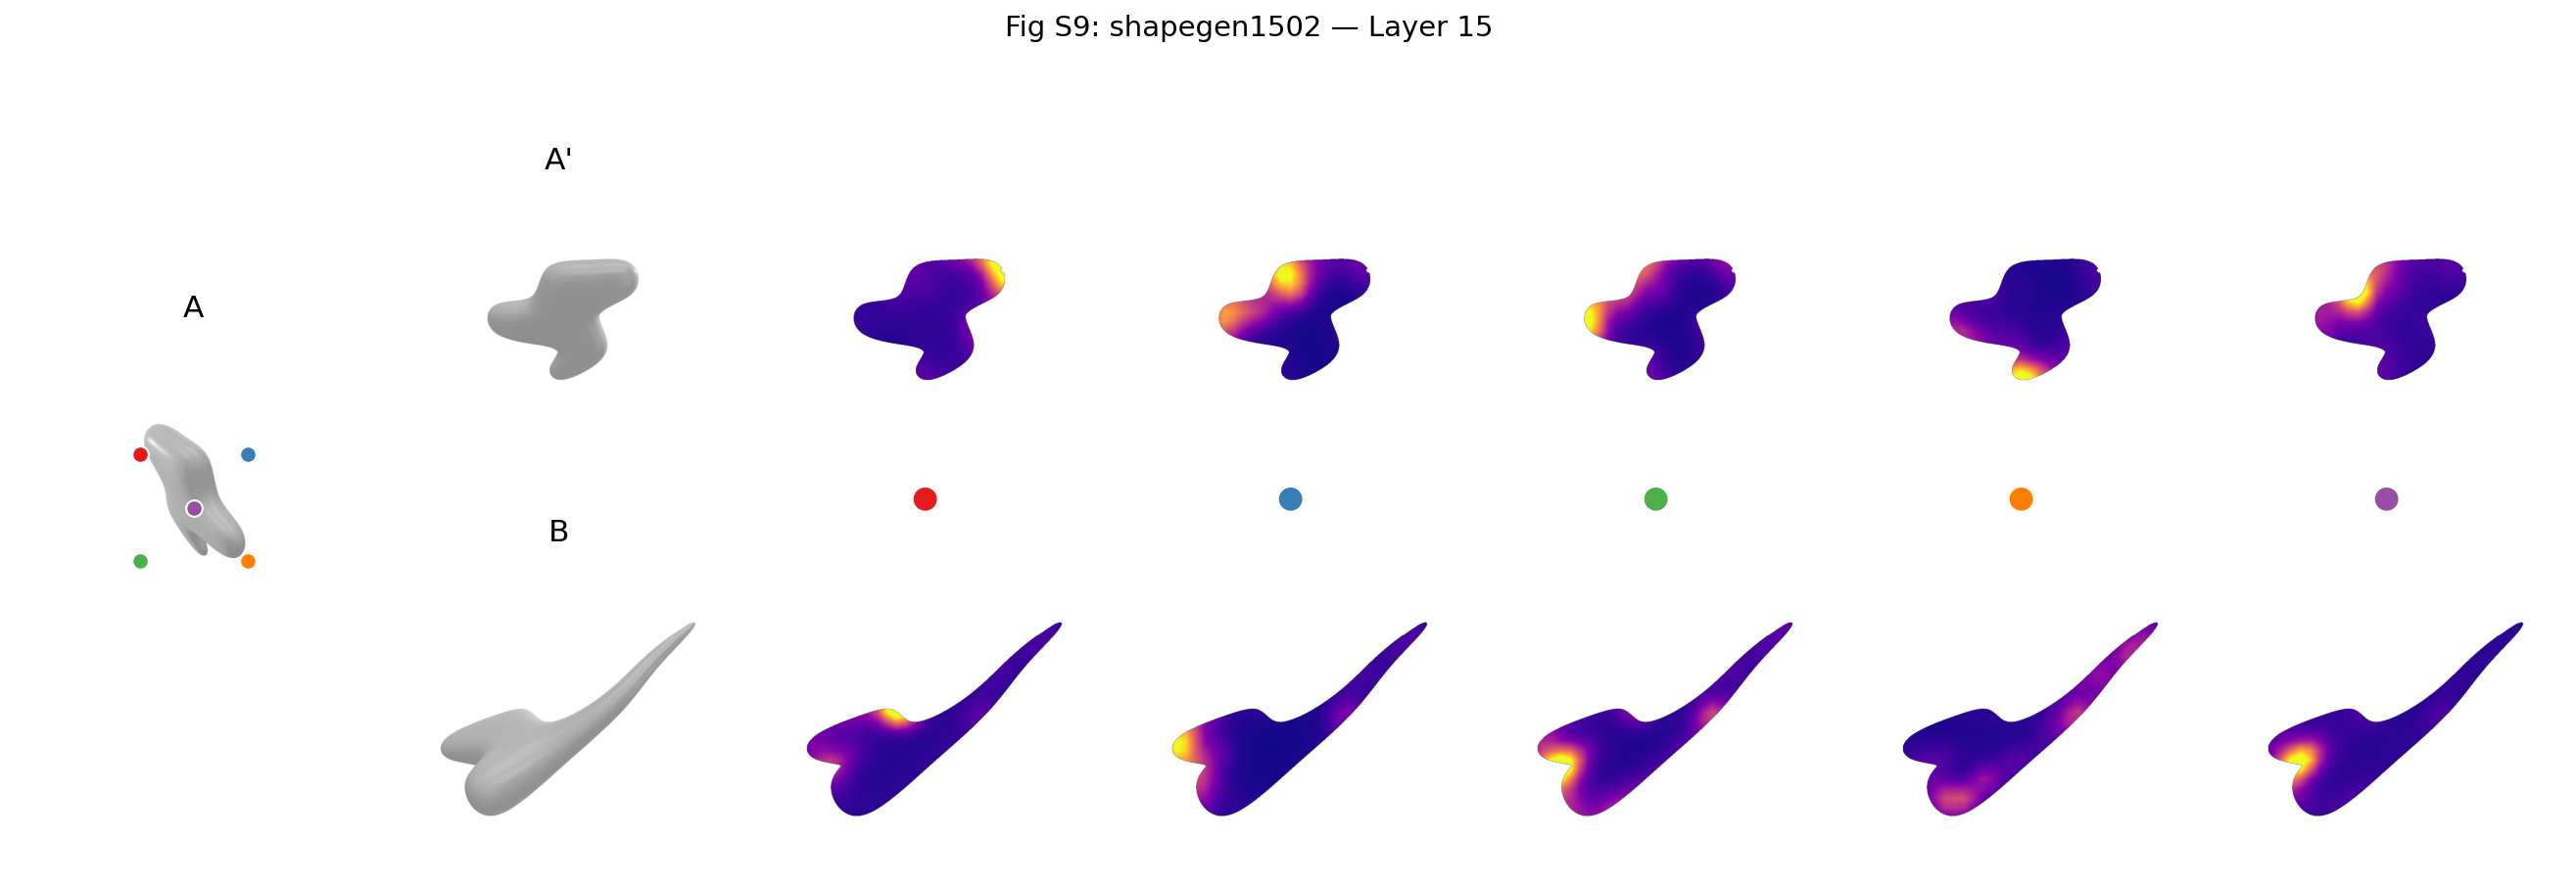

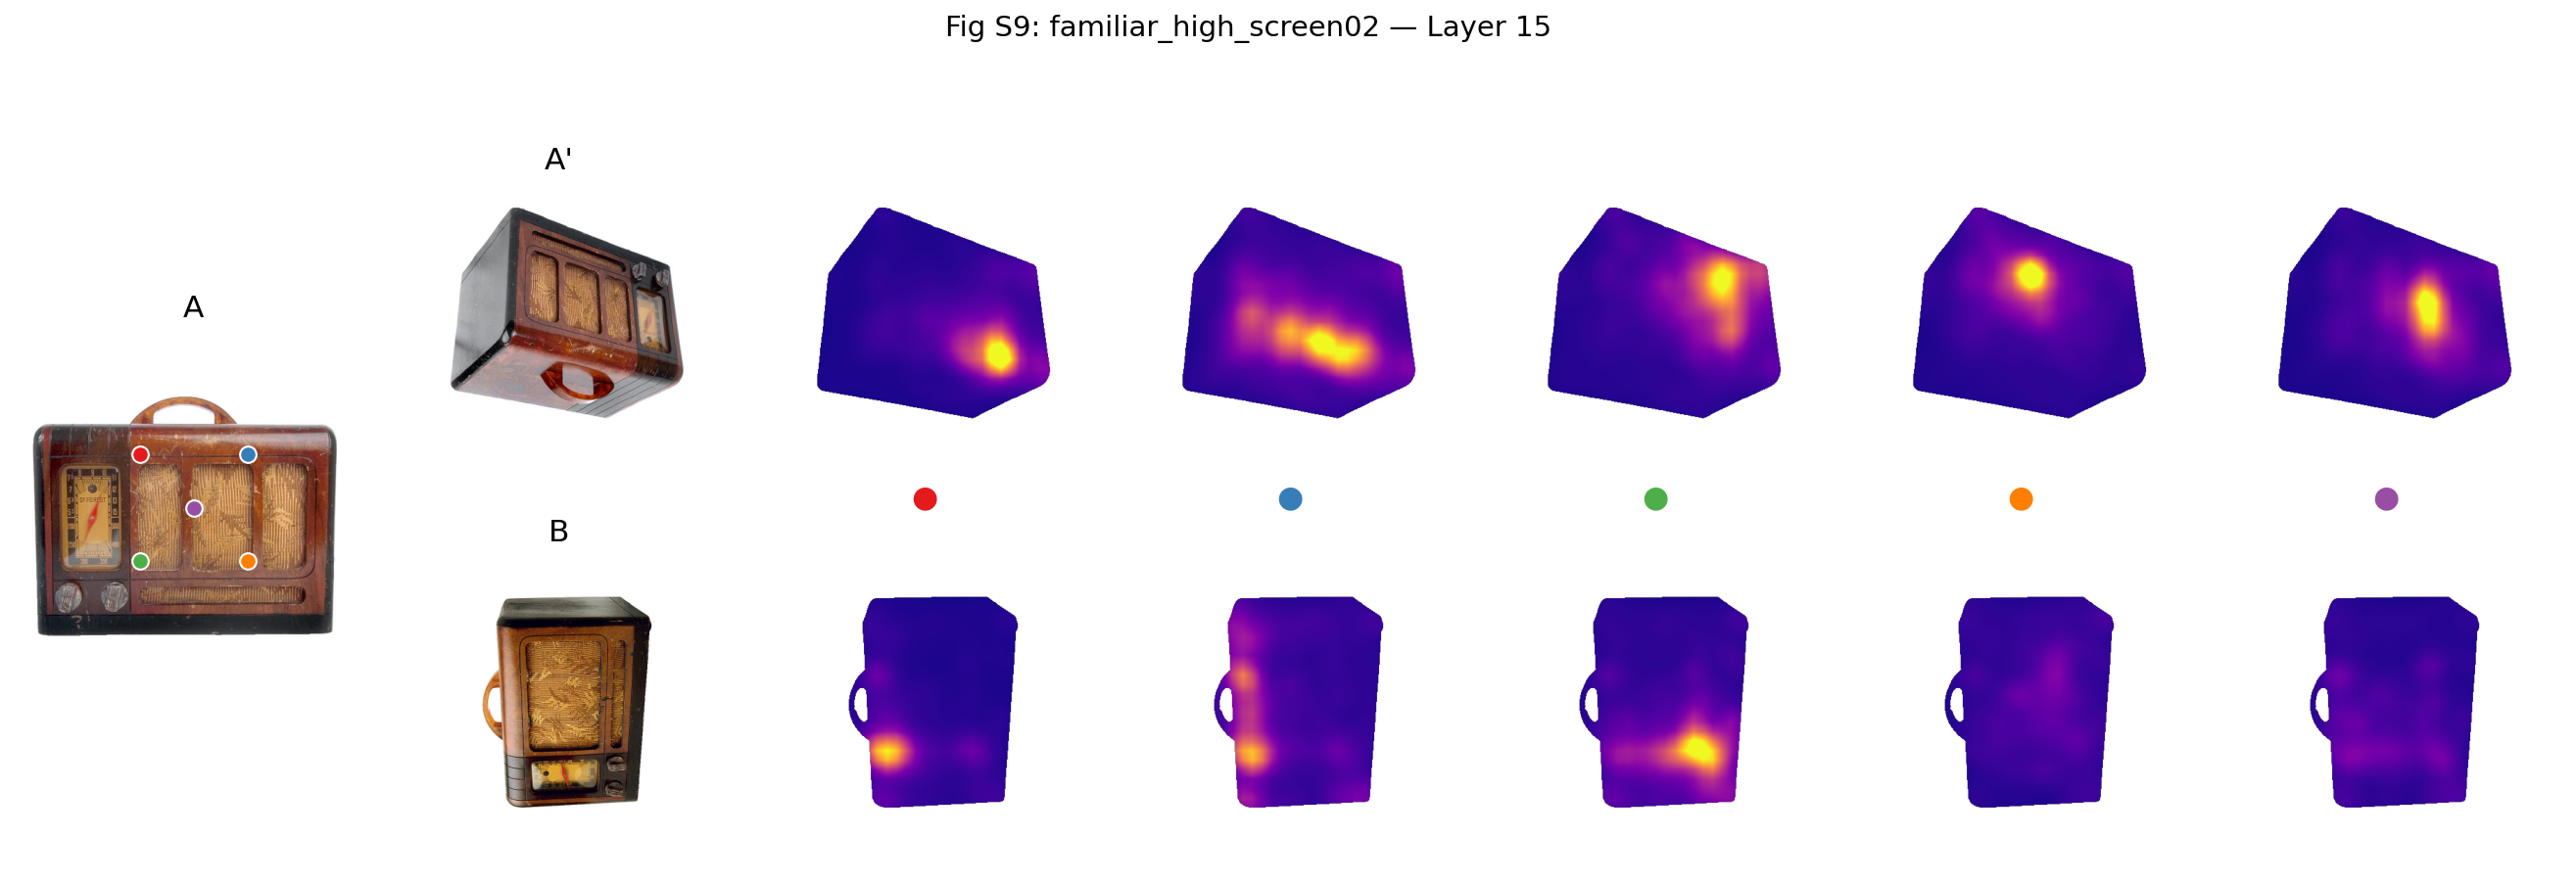

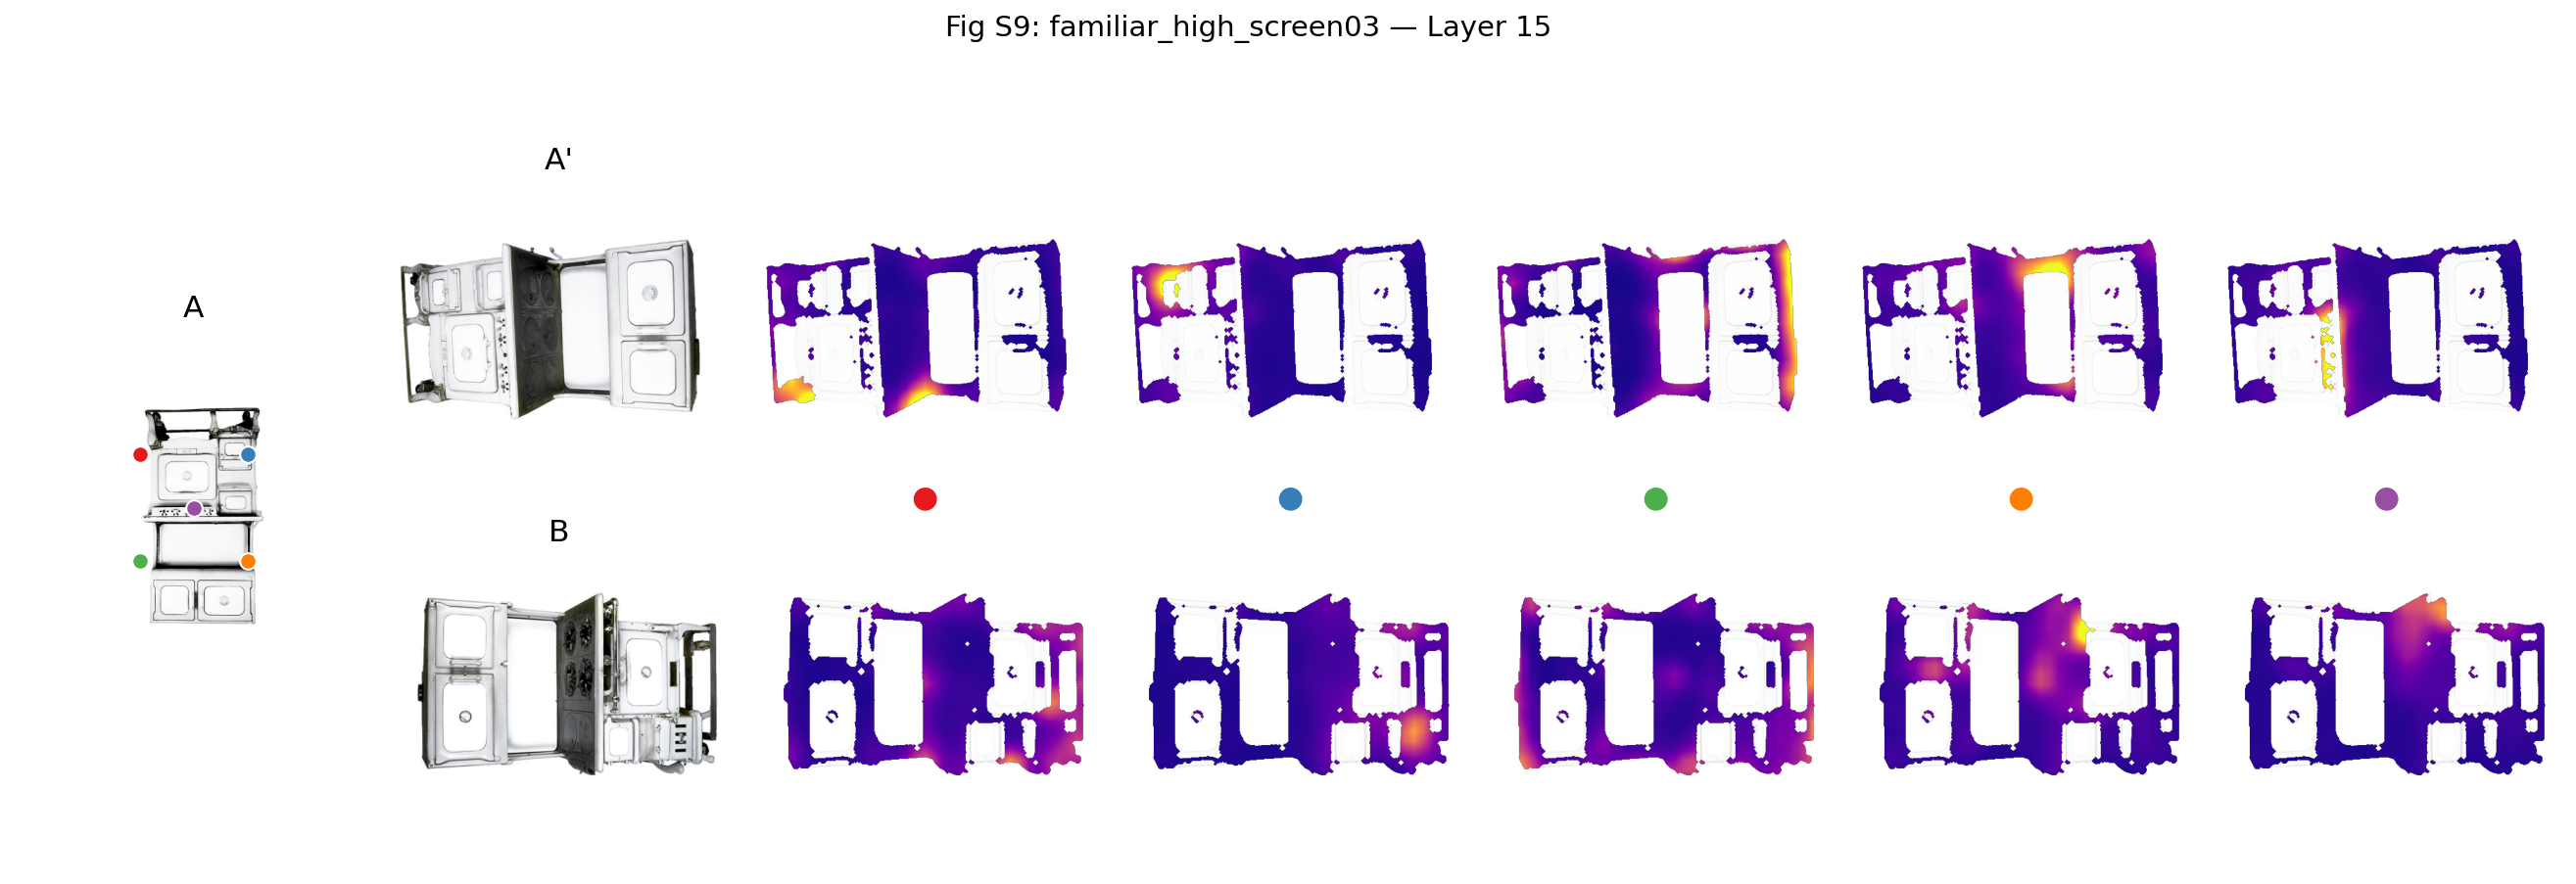

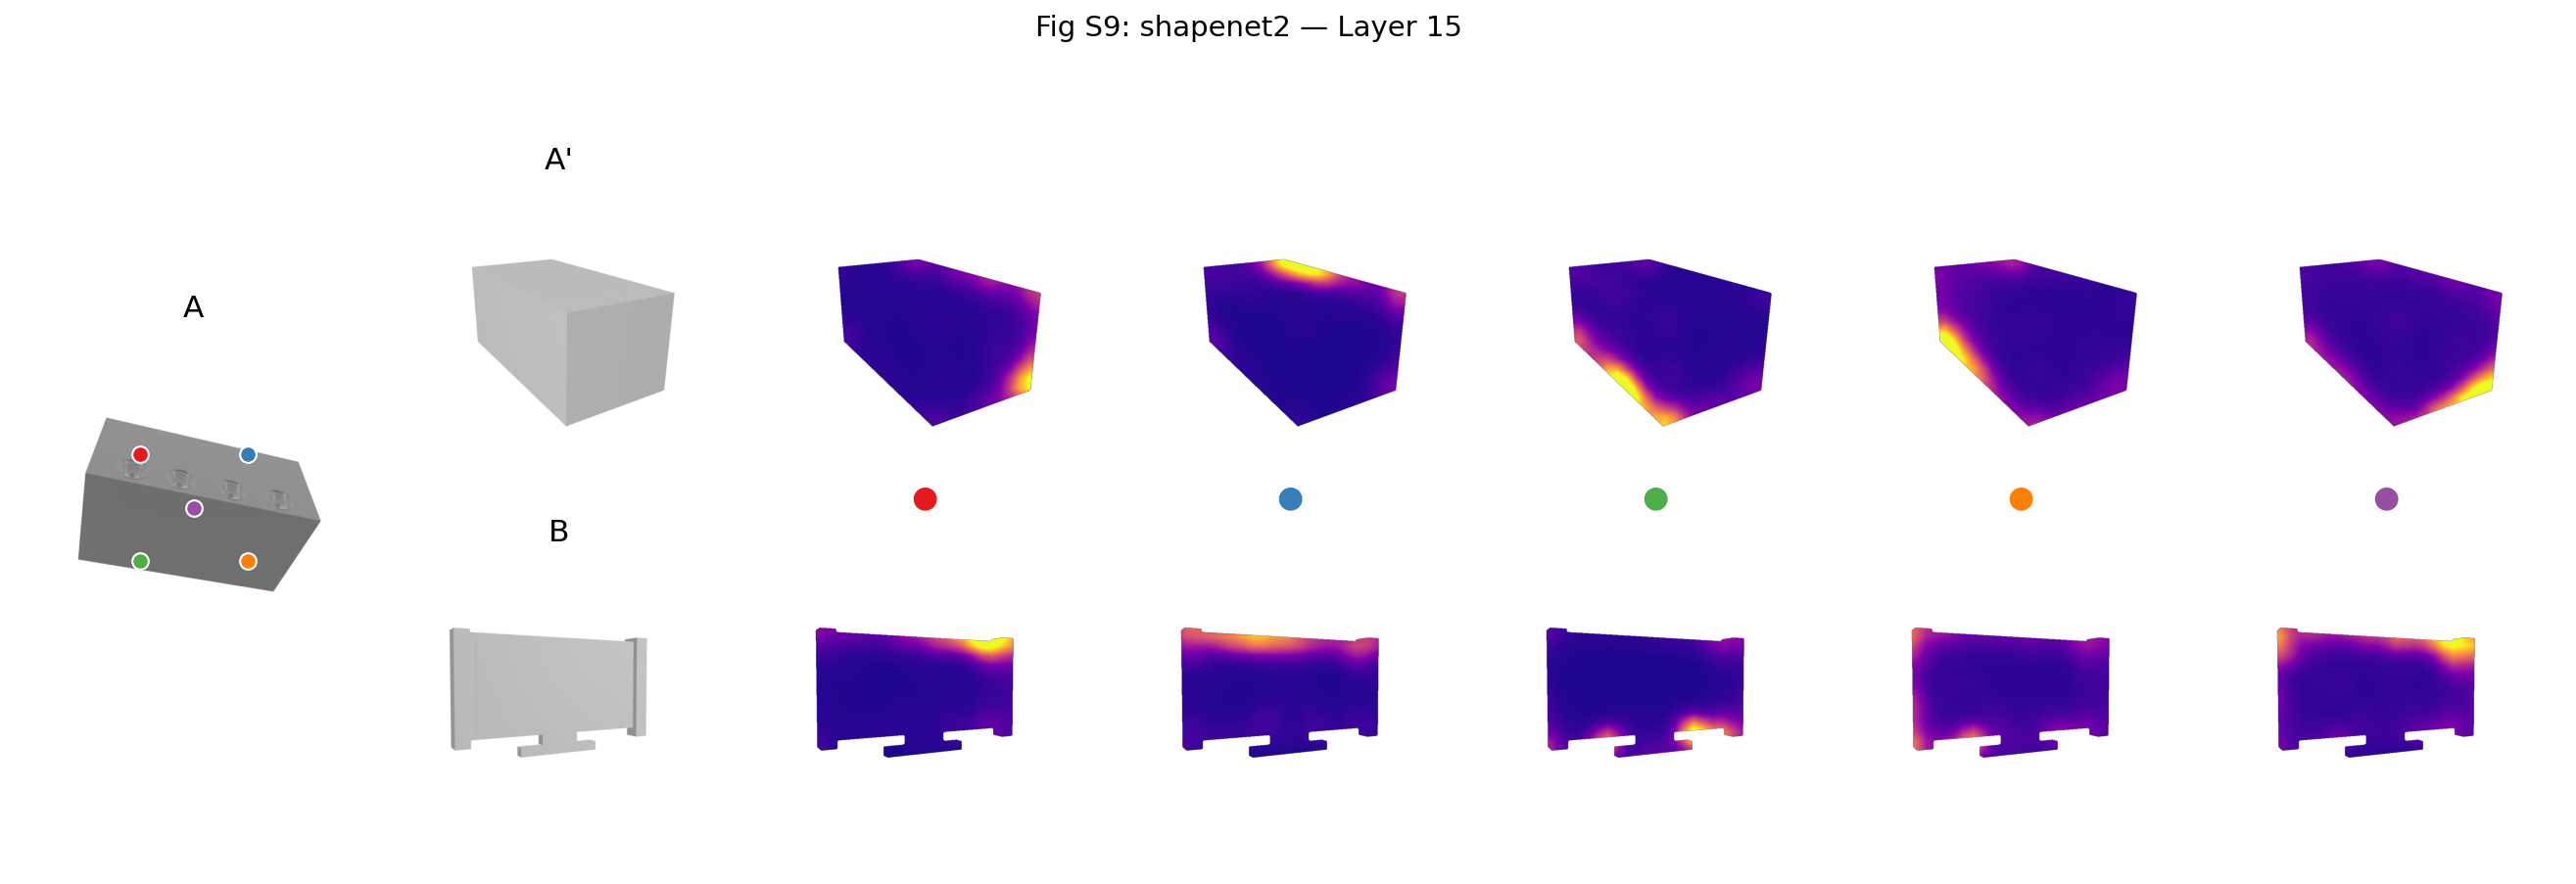

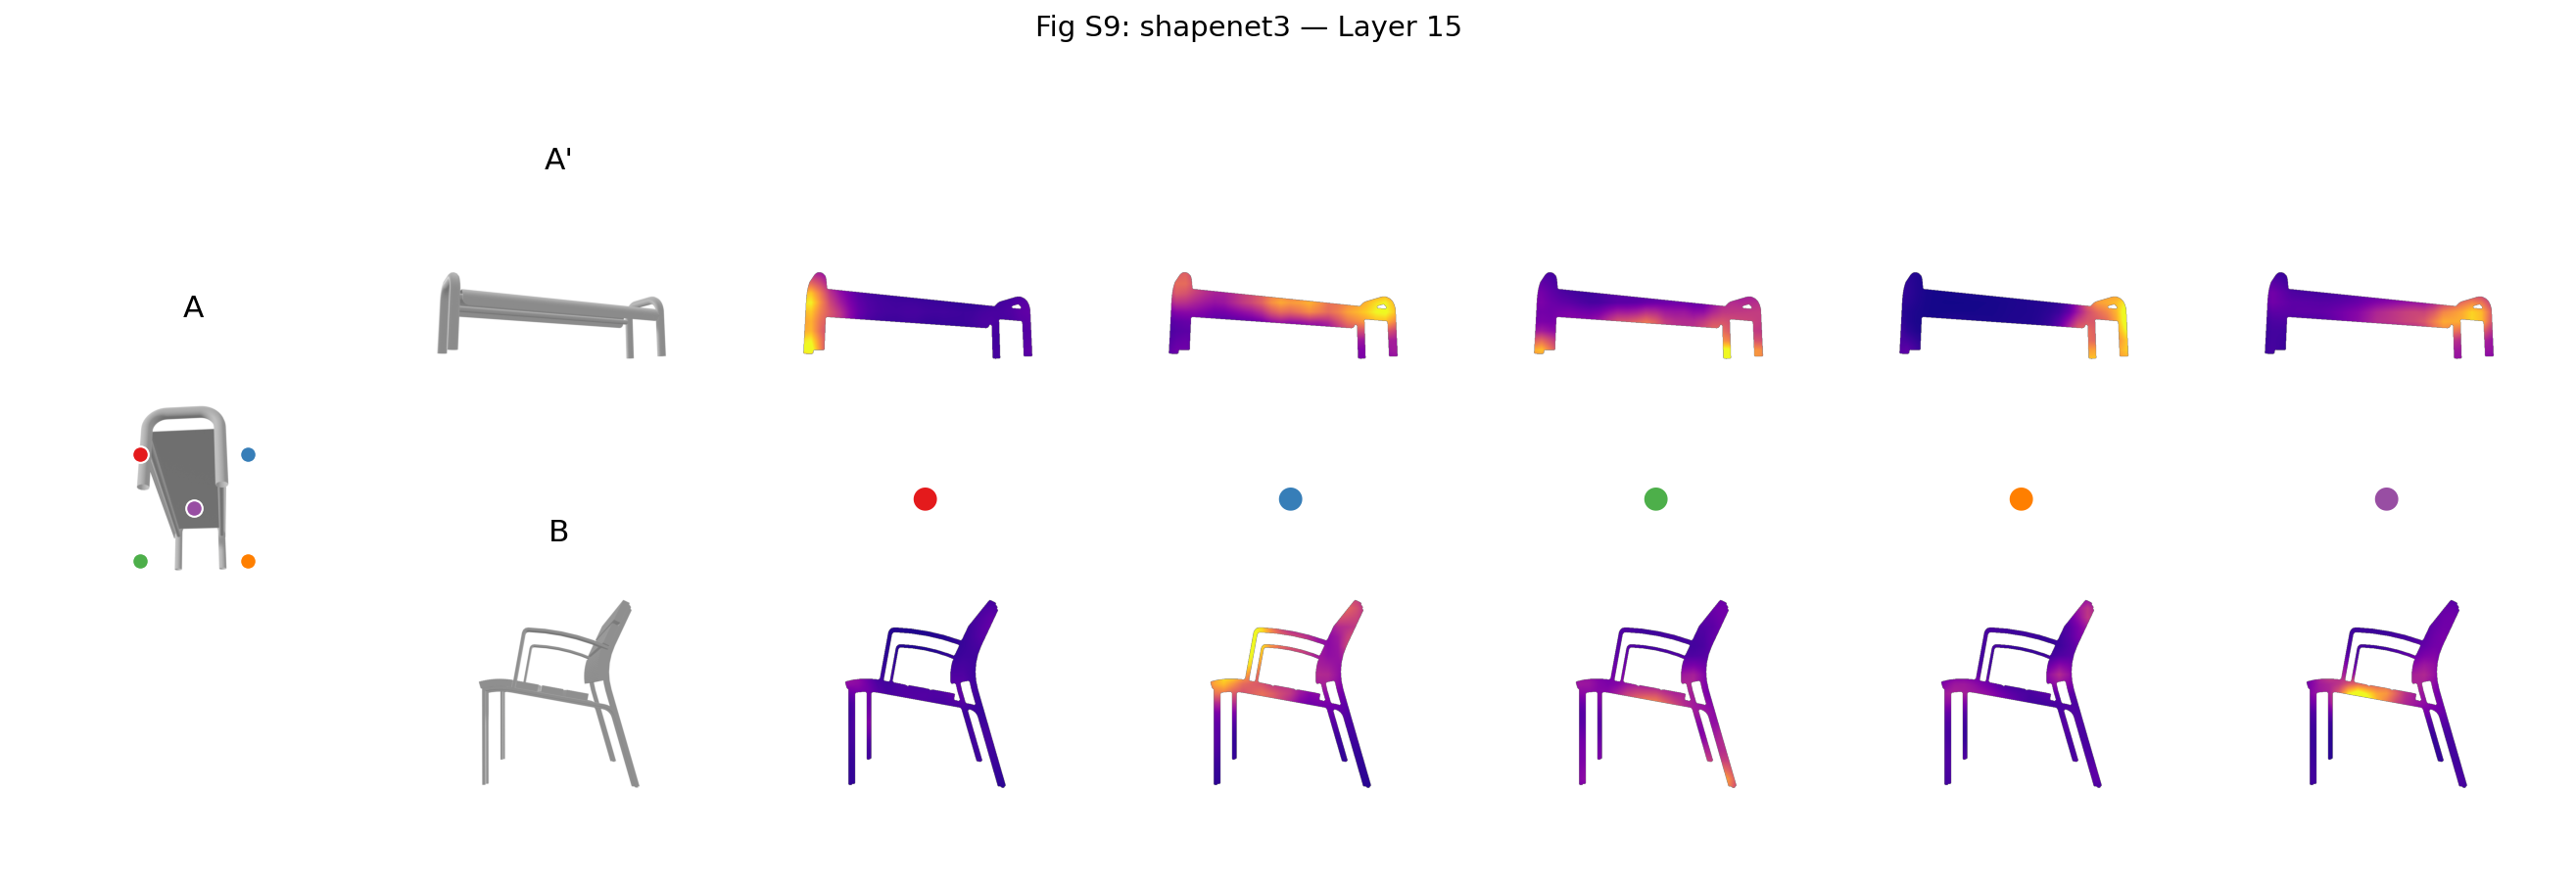

In [8]:
layer = 15

# Additional trials from different conditions
extra_indices = []
for cond_trials in [shapegen_trials[1:], barense_trials[1:], shapenet_trials[:2]]:
    extra_indices.extend(cond_trials)

for trial_idx in extra_indices:
    trial = dataset[trial_idx]
    img_A, img_Ap, img_B, info = get_trial_images(trial)

    w, h = img_A.size
    keypoints = [
        (int(w * 0.35), int(h * 0.35)),
        (int(w * 0.65), int(h * 0.35)),
        (int(w * 0.35), int(h * 0.65)),
        (int(w * 0.65), int(h * 0.65)),
        (int(w * 0.50), int(h * 0.50)),
    ]

    attn_maps_Ap, patch_info = extract_attention(
        vggt, img_A, img_Ap, extractor, (layer,)
    )
    attn_maps_B, _ = extract_attention(
        vggt, img_A, img_B, extractor, (layer,)
    )

    fig = plot_attention_figure(
        img_A, img_Ap, img_B, keypoints,
        attn_maps_Ap, attn_maps_B, patch_info,
        layer=layer, head="mean", sigma=1.0,
        include_B=True, mask_attention=True,
    )
    fig.suptitle(
        f"Fig S9: {info['trial_name']} — Layer {layer}",
        fontsize=14, y=1.02
    )
    plt.savefig(RESULTS_DIR / f"fig_s9_attention_L{layer}_{info['dataset']}_{trial_idx}.pdf",
                bbox_inches="tight")
    plt.show()

    del attn_maps_Ap, attn_maps_B
    clear_gpu_memory()

## Cleanup

In [ ]:
vggt.unload()
print("Model unloaded.")